# Regression Tree / Random forest
This notebook contains the code for generating the random forest regressor. It starts with a single regression tree. We decide the optimal depth and do pruning. The notebook finishes with using an ensemble: the random forest regressor. We perform the same methods on it and compare it with the single regression tree. 

Made by: Yari Anrango

Date: 18-04-23

In [33]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Train, validation, test set

In [2]:
dat = pd.read_csv('pca_dat.csv')
dat = dat.drop('Unnamed: 0', axis = 1)
dat.head()

,0,1,2,3,4,5,6,7,8,9,10,11,mood
0,0.699716,0.246129,0.116635,-0.273108,-0.062836,0.040740,0.079696,0.002588,-0.043754,0.073418,-0.266104,0.087415,0.533333
1,0.400494,0.135455,0.137094,-0.179559,0.033187,0.118881,0.067689,0.009766,-0.055018,0.026952,-0.124208,0.070269,0.566667
2,0.309390,0.055626,0.096834,-0.149769,0.003255,0.131676,0.035541,-0.002411,-0.063246,0.015687,-0.078657,0.049075,0.633333
3,0.362123,0.172488,0.064722,-0.195087,0.076621,0.157589,0.061462,0.044569,-0.062924,0.063388,-0.097793,0.050759,0.500000
4,0.412171,0.071362,0.044727,-0.204008,0.015729,0.201462,0.090661,0.010865,-0.064298,0.055714,-0.069057,0.055631,0.625000


In [3]:
features = dat.drop(['mood'], axis = 1)
target = dat['mood']

train, val, target_train, target_val = train_test_split(features, target, test_size=0.2, random_state=0)
train, test, target_train, target_test = train_test_split(train, target_train, test_size=0.2, random_state=0)

# Decision Tree

## Training

In [4]:
def make_regression_tree(train,train_target,test,test_target, max_depth):
    mse = {}
    rmse = {}
    depths = range(1,max_depth)
    for d in depths:
        regr = DecisionTreeRegressor(max_depth=d)
        regr.fit(train, train_target)
        regr_pred = regr.predict(test)
        mse_ev = mean_squared_error(test_target, regr_pred)
        mse[str(d)] = mse_ev
        
        rmse_ev = mean_squared_error(test_target, regr_pred, squared=False)
        rmse[str(d)] = rmse_ev
    print('lowest mse is found at tree with depth', str(min(mse, key=mse.get)))
    print('lowest rmse is found at tree with depth', str(min(rmse, key=rmse.get)))
    return rmse, mse

In [8]:
rmse, mse = make_regression_tree(train, target_train, val, target_val, max_depth = 40)

lowest mse is found at tree with depth 30
lowest rmse is found at tree with depth 30


Text(0.5, 1.0, 'Score of Regression tree per depth')

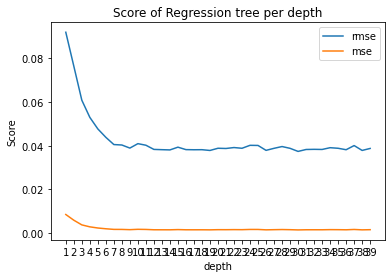

In [12]:
plt.plot(pd.DataFrame({'rmse':rmse,'mse':mse}))
plt.xlabel('depth')
plt.ylabel('Score')
plt.legend(['rmse','mse'])
plt.title('Score of Regression tree per depth')

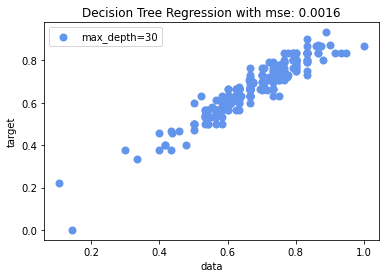

In [18]:
regr = DecisionTreeRegressor(max_depth = 30)
regr.fit(train, target_train)
regr_pred = regr.predict(val)
mse_ev = mean_squared_error(target_val, regr_pred)

plt.figure()
plt.scatter(target_val, regr_pred, color="cornflowerblue", label="max_depth=30", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression with mse: {:.4f}".format(mse_ev))
plt.legend()
plt.show()

## Pruning

In [20]:
regr = DecisionTreeRegressor(max_depth=30)
path = regr.cost_complexity_pruning_path(train, target_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

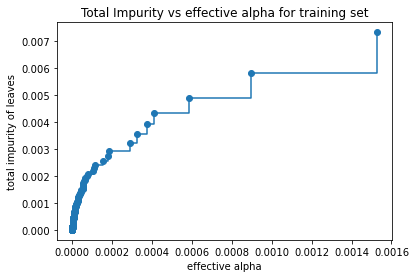

In [21]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [23]:
regrs = []
for ccp_alpha in ccp_alphas:
    regr = DecisionTreeRegressor(max_depth=4, ccp_alpha=ccp_alpha)
    regr.fit(train, target_train)
    regrs.append(regr)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        regrs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.006089162521640211


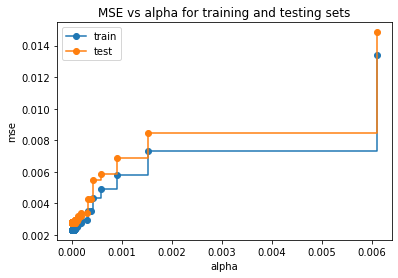

In [24]:
train_scores = []
test_scores = []
for r in regrs: 
    regr_pred_tr = r.predict(train)
    
    mse_tr = mean_squared_error(target_train, regr_pred_tr)
    train_scores.append(mse_tr)
    
    regr_pred_te = r.predict(val)
    
    mse_te = mean_squared_error(target_val, regr_pred_te)
    test_scores.append(mse_te)

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("mse")
ax.set_title("MSE vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

# Random forest regressor

In [26]:
forest = RandomForestRegressor(max_depth=30, random_state=0)
forest.fit(train, target_train)

RandomForestRegressor(max_depth=30, random_state=0)

In [27]:
forest_pred = forest.predict(val)
mse_forest = mean_squared_error(target_val, forest_pred)
mse_forest

0.000714336641984771

Text(0.5, 1.0, 'Performance of Random Forest Regressor with mse: 0.0019')

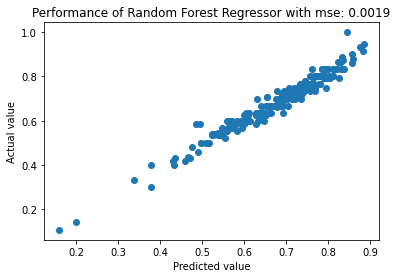

In [28]:
plt.scatter(forest_pred, target_val)
plt.xlabel('Predicted value')
plt.ylabel('Actual value')
plt.title('Performance of Random Forest Regressor with mse: 0.0019')

## Parameter tuning

In [29]:
def test_forest(train,train_target,test,test_target, max_depth):
    mse = {}
    rmse = {}
    depths = range(1,max_depth)
    for d in depths:
        print('training depth =', str(d))
        regr = RandomForestRegressor(max_depth=d, random_state = 0)
        regr.fit(train, train_target)
        regr_pred = regr.predict(test)
        mse_ev = mean_squared_error(test_target, regr_pred)
        mse[str(d)] = mse_ev
        
        rmse_ev = mean_squared_error(test_target, regr_pred, squared=False)
        rmse[str(d)] = rmse_ev
    print('lowest mse is found at tree with depth', str(min(mse, key=mse.get)))
    print('lowest rmse is found at tree with depth', str(min(rmse, key=rmse.get)))
    return rmse, mse

In [30]:
forest_rmse, forest_mse = test_forest(train, target_train, val, target_val, max_depth = 40)

training depth = 1
training depth = 2
training depth = 3
training depth = 4
training depth = 5
training depth = 6
training depth = 7
training depth = 8
training depth = 9
training depth = 10
training depth = 11
training depth = 12
training depth = 13
training depth = 14
training depth = 15
training depth = 16
training depth = 17
training depth = 18
training depth = 19
training depth = 20
training depth = 21
training depth = 22
training depth = 23
training depth = 24
training depth = 25
training depth = 26
training depth = 27
training depth = 28
training depth = 29
training depth = 30
training depth = 31
training depth = 32
training depth = 33
training depth = 34
training depth = 35
training depth = 36
training depth = 37
training depth = 38
training depth = 39
lowest mse is found at tree with depth 13
lowest rmse is found at tree with depth 13


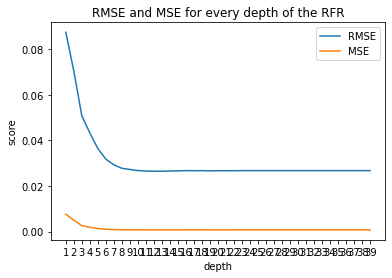

In [31]:
plt.plot(pd.DataFrame({'rmse':forest_rmse,'mse':forest_mse}))
plt.xlabel('depth')
plt.ylabel('score')
plt.title('RMSE and MSE for every depth of the RFR')
plt.legend(['RMSE','MSE'])

It appears that the mse and rmse drop down to a certain level until they will not decrease anymore. As a result we will pick a depth that found the lowest mse and rmse: depth = 13.

## Pruning

In [34]:
forests = []
for ccp_alpha in np.arange(0,0.02, 0.0001):
    print('working on alpha = ',str(ccp_alpha))
    regr = RandomForestRegressor(max_depth=13, ccp_alpha=ccp_alpha)
    regr.fit(train, target_train)
    forests.append(regr)

working on alpha =  0.0
working on alpha =  0.0001
working on alpha =  0.0002
working on alpha =  0.00030000000000000003
working on alpha =  0.0004
working on alpha =  0.0005
working on alpha =  0.0006000000000000001
working on alpha =  0.0007
working on alpha =  0.0008
working on alpha =  0.0009000000000000001
working on alpha =  0.001
working on alpha =  0.0011
working on alpha =  0.0012000000000000001
working on alpha =  0.0013000000000000002
working on alpha =  0.0014
working on alpha =  0.0015
working on alpha =  0.0016
working on alpha =  0.0017000000000000001
working on alpha =  0.0018000000000000002
working on alpha =  0.0019
working on alpha =  0.002
working on alpha =  0.0021000000000000003
working on alpha =  0.0022
working on alpha =  0.0023
working on alpha =  0.0024000000000000002
working on alpha =  0.0025
working on alpha =  0.0026000000000000003
working on alpha =  0.0027
working on alpha =  0.0028
working on alpha =  0.0029000000000000002
working on alpha =  0.003
wor

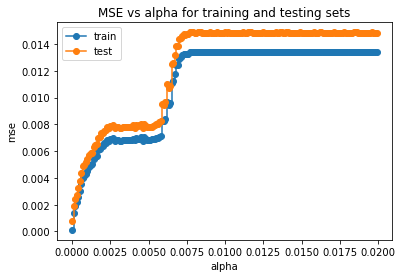

In [35]:
train_scores = []
test_scores = []
for f in forests: 
    regr_pred_tr = f.predict(train)
    
    mse_tr = mean_squared_error(target_train, regr_pred_tr)
    train_scores.append(mse_tr)
    
    regr_pred_te = f.predict(val)
    
    mse_te = mean_squared_error(target_val, regr_pred_te)
    test_scores.append(mse_te)

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("mse")
ax.set_title("MSE vs alpha for training and testing sets")
ax.plot(np.arange(0,0.02, 0.0001), train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(np.arange(0,0.02, 0.0001), test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

It appears that also in this case pruning will not be helpful. We will continue without pruning.

# Final model
The model that performed the best on the validation set was the Random forest regressor with depth = 13 and no pruning. We will use this model on the test set and get the final evaluation.

We will first combine the train and validation set to get a better training set.

In [55]:
train_val = pd.concat([train,val])
target_train_val = pd.concat([target_train, target_val])

In [57]:
forest_final = RandomForestRegressor(max_depth=13, random_state=0)
forest_final.fit(train_val, target_train_val)

RandomForestRegressor(max_depth=13, random_state=0)

In [58]:
forest_final_pred = forest_final.predict(test)
mse_forest = mean_squared_error(target_test, forest_pred)
mse_forest

0.0006838769260951147

Text(0.5, 1.0, 'Performance of Random Forest Regressor with mse: 0.0007')

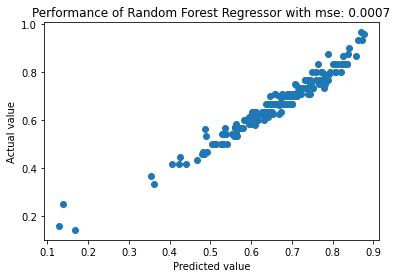

In [59]:
plt.scatter(forest_pred, target_test)
plt.xlabel('Predicted value')
plt.ylabel('Actual value')
plt.title('Performance of Random Forest Regressor with mse: {:.4f}'.format(mse_forest))

# Conclusion

In [67]:
mse_forest


0.0006838769260951147

In [68]:
mse_ev

0.0015667005108556836

After parameter tuning the RandomForestRegressor became the best predictor with an mse of 0.0007, the DecisionTreeRegressor had an mse of 0.0015. 